In [1]:
import pandas as pd 
import numpy as np 
import tensorflow as tf
import os,time,librosa,warnings,glob
import regex as re
from sklearn.metrics import confusion_matrix,classification_report
import librosa.display
from sklearn.preprocessing import MinMaxScaler,OneHotEncoder
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.layers import Dense,Input,Add,Flatten,Dropout,Activation,AveragePooling1D,Conv1D
from keras.models import Model,Sequential,load_model
from keras.optimizers import Adam
from keras.callbacks import LearningRateScheduler,EarlyStopping,ReduceLROnPlateau,ModelCheckpoint
#from google.colab.output import eval_js
from base64 import b64decode
from IPython.display import Audio,HTML
from scipy.io.wavfile import read as wav_read
import io
import ffmpeg
warnings.filterwarnings("ignore")

In [2]:
#decorator function for calculating the total time reqired to execute various function
def calc_time(func):
  def inner(*args, **kwargs):
    st = time.time()
    result = func(*args,**kwargs)
    end = time.time()-st
    print("Total time required: {:.3f} ms".format(end * 1000))
    return result
  return inner

#function for getting ravdess dataset details and labeling
def ravdess_data():
  #directory of the audio dataset
  ravdess = "C:/Users/halaj/OneDrive/Desktop/data/Ravdess/"
  #label ravdess data
  emotion_ravdess = {'01':'neutral','02':'calm','03':'happy','04':'sad','05':'angry','06':'fearful','07':'disgust','08':'surprised'}
  #list to store ravdess emotion
  ravdess_emotion = []
  #list to store ravdess audio path
  ravdess_path = []
  #get subfolders from the path
  ravdess_folder = os.listdir(ravdess)
  for i in ravdess_folder:
    inner_files = os.listdir(ravdess+i+'/')
    for j in inner_files:
      #get the split part which contains the emotion information then append it into lists
      emotion = j.split('-')[2]
      ravdess_path.append(ravdess+i+'/'+j)
      ravdess_emotion.append(emotion_ravdess[emotion])

  #convert to dataframe
  df_ravdess = pd.DataFrame([ravdess_path,ravdess_emotion]).T
  df_ravdess.columns = ["AudioPath","Label"]
  print("length of ravdess dataset",len(df_ravdess))

  return df_ravdess

#function for getting crema dataset details and labeling
def crema_data():
  #directory of the audio dataset
  crema = "C:/Users/halaj/OneDrive/Desktop/data/CREMA-D/AudioWAV/"
  #label ravdess data
  emotion_crema = {'SAD':'sad','ANG':'angry','DIS':'disgust','FEA':'fear','HAP':'happy','NEU':'neutral'}
  #list to store crema emotion
  crema_emotion = []
  #list to store crema audio path
  crema_path = []
  #get crema files in directory
  crema_files = os.listdir(crema)
  for i in crema_files:
    emotion = i.split('_')[2]
    crema_emotion.append(emotion_crema[emotion])
    crema_path.append(crema+i)

  #convert to dataframe
  df_crema = pd.DataFrame([crema_path,crema_emotion]).T
  df_crema.columns = ["AudioPath","Label"]
  print("length of crema dataset",len(df_crema))

  return df_crema

#function for getting tess dataset and labeling
def tess_data():
    #directory of the audio dataset
    tess ="C:/Users/halaj/OneDrive/Desktop/data/TESS Toronto emotional speech set data/"
    tess_emotion = []
    tess_path = []
    tess_folder = os.listdir(tess)
    for i in tess_folder:
        emotion_parts = i.split('_', 1)
        if len(emotion_parts) < 2:
            print("Skipping folder:", i)
            continue
        emotion = emotion_parts[1]
        inner_files = os.listdir(tess + i + '/')
        for j in inner_files:
            tess_path.append(tess + i + '/' + j)
            tess_emotion.append(emotion)

    #convert to dataframe
    df_tess = pd.DataFrame([tess_path,tess_emotion]).T
    df_tess.columns = ["AudioPath","Label"]
    print("length of tess dataset",len(df_tess))

    return df_tess


#function to get savee dataset and labeling
def saveee_data():
  #directory of the audio dataset
  savee = "C:/Users/halaj/OneDrive/Desktop/data/Savee/ALL/"
  emotion_savee = {'a':'anger','d':'disgust','f':'fear','h':'happiness','n':'neutral','sa':'sadness','su':'surprise'}
  savee_emotion = []
  savee_path = []
  savee_files = os.listdir(savee)
  for i in savee_files:
    emotion = i.split('_')[1]
    emotion = re.match(r"([a-z]+)([0-9]+)",emotion)[1]
    savee_emotion.append(emotion_savee[emotion])
    savee_path.append(savee+i)

  #convert to dataframe
  df_savee = pd.DataFrame([savee_path,savee_emotion]).T
  df_savee.columns = ["AudioPath","Label"]
  print("length of savee dataset",len(df_savee))

  return df_savee

@calc_time
def fetch_data():
  #get ravdess data
  df_ravdess = ravdess_data()
  #get crema data
  df_crema = crema_data()
  #get tess data
  df_tess = tess_data()
  #get savee data
  df_savee = saveee_data()
  #combine all four dataset into one single dataset and create a dataframe 
  frames = [df_ravdess,df_crema,df_tess,df_savee]
  final_combined = pd.concat(frames)
  final_combined.reset_index(drop=True,inplace=True)
  #save the information of datasets with their path and labels into a csv file
  final_combined.to_csv('C:/Users/halaj/OneDrive/Desktop/data/preprocesseddata.csv',index=False,header=True)
  print("Total length of the dataset is {}".format(len(final_combined)))
  return final_combined

#below are four data agumentation functions for noise, stretch, shift, pitch
#function to add noise to audio
def noise(data):
  noise_amp = 0.035*np.random.uniform()*np.amax(data)
  data = data + noise_amp*np.random.normal(size=data.shape[0])
  return data

#fuction to strech audio
def stretch(data, rate=0.8):
    return librosa.effects.time_stretch(data, rate=rate)


#fucntion to shift audio range
def shift(data):
  shift_range = int(np.random.uniform(low=-5, high = 5)*1000)
  return np.roll(data, shift_range)

#function to change pitch
def pitch(data, sampling_rate, pitch_factor=0.7):
    return librosa.effects.pitch_shift(data, sr=sampling_rate, n_steps=pitch_factor)



#fuction to extract audio features from the audio files given the information of their path
#path and label information comes from fetch_data fucntion 
#also file preprocesseddata.csv stores the information of paths of audio files their label information
#the print statements are commented these statements were used to see the number of features returned as output
def extract_features(data,sample_rate):  
  
  #zero crossing rate
  result = np.array([])
  zcr = np.mean(librosa.feature.zero_crossing_rate(y=data).T, axis=0)
  result = np.hstack((result, zcr)) 
  #print('zcr',result.shape)

  #chroma shift
  stft = np.abs(librosa.stft(data))
  chroma_stft = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)
  result = np.hstack((result, chroma_stft))
  #print('chroma',result.shape)
  
  #mfcc
  mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sample_rate).T, axis=0)
  result = np.hstack((result, mfcc))
  #print('mfcc',result.shape)
  
  #rmse
  rms = np.mean(librosa.feature.rms(y=data).T, axis=0)
  result = np.hstack((result, rms)) 
  #print('rmse',result.shape)
  
  #melspectogram
  mel = np.mean(librosa.feature.melspectrogram(y=data, sr=sample_rate).T, axis=0)
  result = np.hstack((result, mel)) 
  #print('mel',result.shape)    

  #rollof 
  rollof = np.mean(librosa.feature.spectral_rolloff(y=data, sr=sample_rate).T, axis=0)
  result = np.hstack((result, rollof))
  #print('rollof',result.shape) 

  #centroids 
  centroid = np.mean(librosa.feature.spectral_centroid(y=data, sr=sample_rate).T, axis=0)
  result = np.hstack((result, centroid))
  #print('centroids',result.shape)

  #contrast
  contrast = np.mean(librosa.feature.spectral_contrast(y=data, sr=sample_rate).T, axis=0)
  result = np.hstack((result, contrast))
  #print('contrast',result.shape)

  #bandwidth
  bandwidth = np.mean(librosa.feature.spectral_bandwidth(y=data, sr=sample_rate).T, axis=0)
  result = np.hstack((result, bandwidth))
  #print('bandwidth',result.shape)

  #tonnetz
  tonnetz = np.mean(librosa.feature.tonnetz(y=data, sr=sample_rate).T, axis=0)
  result = np.hstack((result, tonnetz))
  #print('tonnetz',result.shape) 

  return result

#function is used to get all augmented plus original features for given audio file
def get_features(path):
  #set the duration and offset
  #librosa.load takes audio file converts to array and returns array of audio file with its sampling rate
  data, sample_rate = librosa.load(path, duration=2.5, offset=0.6)
    
  #get audio features without augmentation
  res1 = extract_features(data,sample_rate)
  result = np.array(res1)
    
  #get audio features with noise
  noise_data = noise(data)
  res2 = extract_features(noise_data,sample_rate)
  result = np.vstack((result, res2))
    
  #get audio features with stretching and pitching
  new_data = stretch(data)
  data_stretch_pitch = pitch(new_data, sample_rate)
  res3 = extract_features(data_stretch_pitch,sample_rate)
  result = np.vstack((result, res3))
    
  return result

In [3]:
#fucntion one by one takes aduio files from the path extracts features 
#extracted audio features along with their label information are stored in a csv file 
@calc_time
def Audio_features_extract():
  #this function is used to fetch the data from all the four datasets
  df = fetch_data()
  #count is used to keep a check of number of files processed
  count = 0
  #list to store audio features and their label information
  X_data, Y_label = [], []
  #zip audio path and label information and then iterate over them
  for path, emotion in zip(df["AudioPath"], df["Label"]):
    print("Number of files processed ",count)
    #get the features 
    #for one audio file it get three sets of features 
    #original features, features with noise(agumentation) and feature with change in stretch and pitch
    #so one audio file generates three output and the label is same for all the outputs
    feature = get_features(path)
    for ele in feature:
      X_data.append(ele)
      Y_label.append(emotion)
    count+=1
  #create a dataframe of aduio features
  Features = pd.DataFrame(X_data)
  #add label information 
  Features['Label'] = Y_label
  #store the extracted features in a csv file
  Features.to_csv('C:/Users/halaj/OneDrive/Desktop/data/Audio_features_All_pr.csv',index=False)

#this is just one time process so call this function once only to get the features
#once the features are extracted then these features are used for making model
Audio_features_extract()

length of ravdess dataset 1440
length of crema dataset 7442
Skipping folder: TESS Toronto emotional speech set data
length of tess dataset 2800
length of savee dataset 480
Total length of the dataset is 12162
Total time required: 1701.255 ms
Number of files processed  0
Number of files processed  1
Number of files processed  2
Number of files processed  3
Number of files processed  4
Number of files processed  5
Number of files processed  6
Number of files processed  7
Number of files processed  8
Number of files processed  9
Number of files processed  10
Number of files processed  11
Number of files processed  12
Number of files processed  13
Number of files processed  14
Number of files processed  15
Number of files processed  16
Number of files processed  17
Number of files processed  18
Number of files processed  19
Number of files processed  20
Number of files processed  21
Number of files processed  22
Number of files processed  23
Number of files processed  24
Number of files pr

Number of files processed  1825
Number of files processed  1826
Number of files processed  1827
Number of files processed  1828
Number of files processed  1829
Number of files processed  1830
Number of files processed  1831
Number of files processed  1832
Number of files processed  1833
Number of files processed  1834
Number of files processed  1835
Number of files processed  1836
Number of files processed  1837
Number of files processed  1838
Number of files processed  1839
Number of files processed  1840
Number of files processed  1841
Number of files processed  1842
Number of files processed  1843
Number of files processed  1844
Number of files processed  1845
Number of files processed  1846
Number of files processed  1847
Number of files processed  1848
Number of files processed  1849
Number of files processed  1850
Number of files processed  1851
Number of files processed  1852
Number of files processed  1853
Number of files processed  1854
Number of files processed  1855
Number o

Number of files processed  2082
Number of files processed  2083
Number of files processed  2084
Number of files processed  2085
Number of files processed  2086
Number of files processed  2087
Number of files processed  2088
Number of files processed  2089
Number of files processed  2090
Number of files processed  2091
Number of files processed  2092
Number of files processed  2093
Number of files processed  2094
Number of files processed  2095
Number of files processed  2096
Number of files processed  2097
Number of files processed  2098
Number of files processed  2099
Number of files processed  2100
Number of files processed  2101
Number of files processed  2102
Number of files processed  2103
Number of files processed  2104
Number of files processed  2105
Number of files processed  2106
Number of files processed  2107
Number of files processed  2108
Number of files processed  2109
Number of files processed  2110
Number of files processed  2111
Number of files processed  2112
Number o

Number of files processed  2339
Number of files processed  2340
Number of files processed  2341
Number of files processed  2342
Number of files processed  2343
Number of files processed  2344
Number of files processed  2345
Number of files processed  2346
Number of files processed  2347
Number of files processed  2348
Number of files processed  2349
Number of files processed  2350
Number of files processed  2351
Number of files processed  2352
Number of files processed  2353
Number of files processed  2354
Number of files processed  2355
Number of files processed  2356
Number of files processed  2357
Number of files processed  2358
Number of files processed  2359
Number of files processed  2360
Number of files processed  2361
Number of files processed  2362
Number of files processed  2363
Number of files processed  2364
Number of files processed  2365
Number of files processed  2366
Number of files processed  2367
Number of files processed  2368
Number of files processed  2369
Number o

Number of files processed  2596
Number of files processed  2597
Number of files processed  2598
Number of files processed  2599
Number of files processed  2600
Number of files processed  2601
Number of files processed  2602
Number of files processed  2603
Number of files processed  2604
Number of files processed  2605
Number of files processed  2606
Number of files processed  2607
Number of files processed  2608
Number of files processed  2609
Number of files processed  2610
Number of files processed  2611
Number of files processed  2612
Number of files processed  2613
Number of files processed  2614
Number of files processed  2615
Number of files processed  2616
Number of files processed  2617
Number of files processed  2618
Number of files processed  2619
Number of files processed  2620
Number of files processed  2621
Number of files processed  2622
Number of files processed  2623
Number of files processed  2624
Number of files processed  2625
Number of files processed  2626
Number o

Number of files processed  2853
Number of files processed  2854
Number of files processed  2855
Number of files processed  2856
Number of files processed  2857
Number of files processed  2858
Number of files processed  2859
Number of files processed  2860
Number of files processed  2861
Number of files processed  2862
Number of files processed  2863
Number of files processed  2864
Number of files processed  2865
Number of files processed  2866
Number of files processed  2867
Number of files processed  2868
Number of files processed  2869
Number of files processed  2870
Number of files processed  2871
Number of files processed  2872
Number of files processed  2873
Number of files processed  2874
Number of files processed  2875
Number of files processed  2876
Number of files processed  2877
Number of files processed  2878
Number of files processed  2879
Number of files processed  2880
Number of files processed  2881
Number of files processed  2882
Number of files processed  2883
Number o

Number of files processed  3110
Number of files processed  3111
Number of files processed  3112
Number of files processed  3113
Number of files processed  3114
Number of files processed  3115
Number of files processed  3116
Number of files processed  3117
Number of files processed  3118
Number of files processed  3119
Number of files processed  3120
Number of files processed  3121
Number of files processed  3122
Number of files processed  3123
Number of files processed  3124
Number of files processed  3125
Number of files processed  3126
Number of files processed  3127
Number of files processed  3128
Number of files processed  3129
Number of files processed  3130
Number of files processed  3131
Number of files processed  3132
Number of files processed  3133
Number of files processed  3134
Number of files processed  3135
Number of files processed  3136
Number of files processed  3137
Number of files processed  3138
Number of files processed  3139
Number of files processed  3140
Number o

Number of files processed  3367
Number of files processed  3368
Number of files processed  3369
Number of files processed  3370
Number of files processed  3371
Number of files processed  3372
Number of files processed  3373
Number of files processed  3374
Number of files processed  3375
Number of files processed  3376
Number of files processed  3377
Number of files processed  3378
Number of files processed  3379
Number of files processed  3380
Number of files processed  3381
Number of files processed  3382
Number of files processed  3383
Number of files processed  3384
Number of files processed  3385
Number of files processed  3386
Number of files processed  3387
Number of files processed  3388
Number of files processed  3389
Number of files processed  3390
Number of files processed  3391
Number of files processed  3392
Number of files processed  3393
Number of files processed  3394
Number of files processed  3395
Number of files processed  3396
Number of files processed  3397
Number o

Number of files processed  3624
Number of files processed  3625
Number of files processed  3626
Number of files processed  3627
Number of files processed  3628
Number of files processed  3629
Number of files processed  3630
Number of files processed  3631
Number of files processed  3632
Number of files processed  3633
Number of files processed  3634
Number of files processed  3635
Number of files processed  3636
Number of files processed  3637
Number of files processed  3638
Number of files processed  3639
Number of files processed  3640
Number of files processed  3641
Number of files processed  3642
Number of files processed  3643
Number of files processed  3644
Number of files processed  3645
Number of files processed  3646
Number of files processed  3647
Number of files processed  3648
Number of files processed  3649
Number of files processed  3650
Number of files processed  3651
Number of files processed  3652
Number of files processed  3653
Number of files processed  3654
Number o

Number of files processed  3881
Number of files processed  3882
Number of files processed  3883
Number of files processed  3884
Number of files processed  3885
Number of files processed  3886
Number of files processed  3887
Number of files processed  3888
Number of files processed  3889
Number of files processed  3890
Number of files processed  3891
Number of files processed  3892
Number of files processed  3893
Number of files processed  3894
Number of files processed  3895
Number of files processed  3896
Number of files processed  3897
Number of files processed  3898
Number of files processed  3899
Number of files processed  3900
Number of files processed  3901
Number of files processed  3902
Number of files processed  3903
Number of files processed  3904
Number of files processed  3905
Number of files processed  3906
Number of files processed  3907
Number of files processed  3908
Number of files processed  3909
Number of files processed  3910
Number of files processed  3911
Number o

Number of files processed  4138
Number of files processed  4139
Number of files processed  4140
Number of files processed  4141
Number of files processed  4142
Number of files processed  4143
Number of files processed  4144
Number of files processed  4145
Number of files processed  4146
Number of files processed  4147
Number of files processed  4148
Number of files processed  4149
Number of files processed  4150
Number of files processed  4151
Number of files processed  4152
Number of files processed  4153
Number of files processed  4154
Number of files processed  4155
Number of files processed  4156
Number of files processed  4157
Number of files processed  4158
Number of files processed  4159
Number of files processed  4160
Number of files processed  4161
Number of files processed  4162
Number of files processed  4163
Number of files processed  4164
Number of files processed  4165
Number of files processed  4166
Number of files processed  4167
Number of files processed  4168
Number o

Number of files processed  4395
Number of files processed  4396
Number of files processed  4397
Number of files processed  4398
Number of files processed  4399
Number of files processed  4400
Number of files processed  4401
Number of files processed  4402
Number of files processed  4403
Number of files processed  4404
Number of files processed  4405
Number of files processed  4406
Number of files processed  4407
Number of files processed  4408
Number of files processed  4409
Number of files processed  4410
Number of files processed  4411
Number of files processed  4412
Number of files processed  4413
Number of files processed  4414
Number of files processed  4415
Number of files processed  4416
Number of files processed  4417
Number of files processed  4418
Number of files processed  4419
Number of files processed  4420
Number of files processed  4421
Number of files processed  4422
Number of files processed  4423
Number of files processed  4424
Number of files processed  4425
Number o

Number of files processed  4652
Number of files processed  4653
Number of files processed  4654
Number of files processed  4655
Number of files processed  4656
Number of files processed  4657
Number of files processed  4658
Number of files processed  4659
Number of files processed  4660
Number of files processed  4661
Number of files processed  4662
Number of files processed  4663
Number of files processed  4664
Number of files processed  4665
Number of files processed  4666
Number of files processed  4667
Number of files processed  4668
Number of files processed  4669
Number of files processed  4670
Number of files processed  4671
Number of files processed  4672
Number of files processed  4673
Number of files processed  4674
Number of files processed  4675
Number of files processed  4676
Number of files processed  4677
Number of files processed  4678
Number of files processed  4679
Number of files processed  4680
Number of files processed  4681
Number of files processed  4682
Number o

Number of files processed  4909
Number of files processed  4910
Number of files processed  4911
Number of files processed  4912
Number of files processed  4913
Number of files processed  4914
Number of files processed  4915
Number of files processed  4916
Number of files processed  4917
Number of files processed  4918
Number of files processed  4919
Number of files processed  4920
Number of files processed  4921
Number of files processed  4922
Number of files processed  4923
Number of files processed  4924
Number of files processed  4925
Number of files processed  4926
Number of files processed  4927
Number of files processed  4928
Number of files processed  4929
Number of files processed  4930
Number of files processed  4931
Number of files processed  4932
Number of files processed  4933
Number of files processed  4934
Number of files processed  4935
Number of files processed  4936
Number of files processed  4937
Number of files processed  4938
Number of files processed  4939
Number o

Number of files processed  5166
Number of files processed  5167
Number of files processed  5168
Number of files processed  5169
Number of files processed  5170
Number of files processed  5171
Number of files processed  5172
Number of files processed  5173
Number of files processed  5174
Number of files processed  5175
Number of files processed  5176
Number of files processed  5177
Number of files processed  5178
Number of files processed  5179
Number of files processed  5180
Number of files processed  5181
Number of files processed  5182
Number of files processed  5183
Number of files processed  5184
Number of files processed  5185
Number of files processed  5186
Number of files processed  5187
Number of files processed  5188
Number of files processed  5189
Number of files processed  5190
Number of files processed  5191
Number of files processed  5192
Number of files processed  5193
Number of files processed  5194
Number of files processed  5195
Number of files processed  5196
Number o

Number of files processed  5423
Number of files processed  5424
Number of files processed  5425
Number of files processed  5426
Number of files processed  5427
Number of files processed  5428
Number of files processed  5429
Number of files processed  5430
Number of files processed  5431
Number of files processed  5432
Number of files processed  5433
Number of files processed  5434
Number of files processed  5435
Number of files processed  5436
Number of files processed  5437
Number of files processed  5438
Number of files processed  5439
Number of files processed  5440
Number of files processed  5441
Number of files processed  5442
Number of files processed  5443
Number of files processed  5444
Number of files processed  5445
Number of files processed  5446
Number of files processed  5447
Number of files processed  5448
Number of files processed  5449
Number of files processed  5450
Number of files processed  5451
Number of files processed  5452
Number of files processed  5453
Number o

Number of files processed  5680
Number of files processed  5681
Number of files processed  5682
Number of files processed  5683
Number of files processed  5684
Number of files processed  5685
Number of files processed  5686
Number of files processed  5687
Number of files processed  5688
Number of files processed  5689
Number of files processed  5690
Number of files processed  5691
Number of files processed  5692
Number of files processed  5693
Number of files processed  5694
Number of files processed  5695
Number of files processed  5696
Number of files processed  5697
Number of files processed  5698
Number of files processed  5699
Number of files processed  5700
Number of files processed  5701
Number of files processed  5702
Number of files processed  5703
Number of files processed  5704
Number of files processed  5705
Number of files processed  5706
Number of files processed  5707
Number of files processed  5708
Number of files processed  5709
Number of files processed  5710
Number o

Number of files processed  5937
Number of files processed  5938
Number of files processed  5939
Number of files processed  5940
Number of files processed  5941
Number of files processed  5942
Number of files processed  5943
Number of files processed  5944
Number of files processed  5945
Number of files processed  5946
Number of files processed  5947
Number of files processed  5948
Number of files processed  5949
Number of files processed  5950
Number of files processed  5951
Number of files processed  5952
Number of files processed  5953
Number of files processed  5954
Number of files processed  5955
Number of files processed  5956
Number of files processed  5957
Number of files processed  5958
Number of files processed  5959
Number of files processed  5960
Number of files processed  5961
Number of files processed  5962
Number of files processed  5963
Number of files processed  5964
Number of files processed  5965
Number of files processed  5966
Number of files processed  5967
Number o

Number of files processed  6194
Number of files processed  6195
Number of files processed  6196
Number of files processed  6197
Number of files processed  6198
Number of files processed  6199
Number of files processed  6200
Number of files processed  6201
Number of files processed  6202
Number of files processed  6203
Number of files processed  6204
Number of files processed  6205
Number of files processed  6206
Number of files processed  6207
Number of files processed  6208
Number of files processed  6209
Number of files processed  6210
Number of files processed  6211
Number of files processed  6212
Number of files processed  6213
Number of files processed  6214
Number of files processed  6215
Number of files processed  6216
Number of files processed  6217
Number of files processed  6218
Number of files processed  6219
Number of files processed  6220
Number of files processed  6221
Number of files processed  6222
Number of files processed  6223
Number of files processed  6224
Number o

Number of files processed  6451
Number of files processed  6452
Number of files processed  6453
Number of files processed  6454
Number of files processed  6455
Number of files processed  6456
Number of files processed  6457
Number of files processed  6458
Number of files processed  6459
Number of files processed  6460
Number of files processed  6461
Number of files processed  6462
Number of files processed  6463
Number of files processed  6464
Number of files processed  6465
Number of files processed  6466
Number of files processed  6467
Number of files processed  6468
Number of files processed  6469
Number of files processed  6470
Number of files processed  6471
Number of files processed  6472
Number of files processed  6473
Number of files processed  6474
Number of files processed  6475
Number of files processed  6476
Number of files processed  6477
Number of files processed  6478
Number of files processed  6479
Number of files processed  6480
Number of files processed  6481
Number o

Number of files processed  6708
Number of files processed  6709
Number of files processed  6710
Number of files processed  6711
Number of files processed  6712
Number of files processed  6713
Number of files processed  6714
Number of files processed  6715
Number of files processed  6716
Number of files processed  6717
Number of files processed  6718
Number of files processed  6719
Number of files processed  6720
Number of files processed  6721
Number of files processed  6722
Number of files processed  6723
Number of files processed  6724
Number of files processed  6725
Number of files processed  6726
Number of files processed  6727
Number of files processed  6728
Number of files processed  6729
Number of files processed  6730
Number of files processed  6731
Number of files processed  6732
Number of files processed  6733
Number of files processed  6734
Number of files processed  6735
Number of files processed  6736
Number of files processed  6737
Number of files processed  6738
Number o

Number of files processed  6965
Number of files processed  6966
Number of files processed  6967
Number of files processed  6968
Number of files processed  6969
Number of files processed  6970
Number of files processed  6971
Number of files processed  6972
Number of files processed  6973
Number of files processed  6974
Number of files processed  6975
Number of files processed  6976
Number of files processed  6977
Number of files processed  6978
Number of files processed  6979
Number of files processed  6980
Number of files processed  6981
Number of files processed  6982
Number of files processed  6983
Number of files processed  6984
Number of files processed  6985
Number of files processed  6986
Number of files processed  6987
Number of files processed  6988
Number of files processed  6989
Number of files processed  6990
Number of files processed  6991
Number of files processed  6992
Number of files processed  6993
Number of files processed  6994
Number of files processed  6995
Number o

Number of files processed  7222
Number of files processed  7223
Number of files processed  7224
Number of files processed  7225
Number of files processed  7226
Number of files processed  7227
Number of files processed  7228
Number of files processed  7229
Number of files processed  7230
Number of files processed  7231
Number of files processed  7232
Number of files processed  7233
Number of files processed  7234
Number of files processed  7235
Number of files processed  7236
Number of files processed  7237
Number of files processed  7238
Number of files processed  7239
Number of files processed  7240
Number of files processed  7241
Number of files processed  7242
Number of files processed  7243
Number of files processed  7244
Number of files processed  7245
Number of files processed  7246
Number of files processed  7247
Number of files processed  7248
Number of files processed  7249
Number of files processed  7250
Number of files processed  7251
Number of files processed  7252
Number o

Number of files processed  7479
Number of files processed  7480
Number of files processed  7481
Number of files processed  7482
Number of files processed  7483
Number of files processed  7484
Number of files processed  7485
Number of files processed  7486
Number of files processed  7487
Number of files processed  7488
Number of files processed  7489
Number of files processed  7490
Number of files processed  7491
Number of files processed  7492
Number of files processed  7493
Number of files processed  7494
Number of files processed  7495
Number of files processed  7496
Number of files processed  7497
Number of files processed  7498
Number of files processed  7499
Number of files processed  7500
Number of files processed  7501
Number of files processed  7502
Number of files processed  7503
Number of files processed  7504
Number of files processed  7505
Number of files processed  7506
Number of files processed  7507
Number of files processed  7508
Number of files processed  7509
Number o

Number of files processed  7736
Number of files processed  7737
Number of files processed  7738
Number of files processed  7739
Number of files processed  7740
Number of files processed  7741
Number of files processed  7742
Number of files processed  7743
Number of files processed  7744
Number of files processed  7745
Number of files processed  7746
Number of files processed  7747
Number of files processed  7748
Number of files processed  7749
Number of files processed  7750
Number of files processed  7751
Number of files processed  7752
Number of files processed  7753
Number of files processed  7754
Number of files processed  7755
Number of files processed  7756
Number of files processed  7757
Number of files processed  7758
Number of files processed  7759
Number of files processed  7760
Number of files processed  7761
Number of files processed  7762
Number of files processed  7763
Number of files processed  7764
Number of files processed  7765
Number of files processed  7766
Number o

Number of files processed  7993
Number of files processed  7994
Number of files processed  7995
Number of files processed  7996
Number of files processed  7997
Number of files processed  7998
Number of files processed  7999
Number of files processed  8000
Number of files processed  8001
Number of files processed  8002
Number of files processed  8003
Number of files processed  8004
Number of files processed  8005
Number of files processed  8006
Number of files processed  8007
Number of files processed  8008
Number of files processed  8009
Number of files processed  8010
Number of files processed  8011
Number of files processed  8012
Number of files processed  8013
Number of files processed  8014
Number of files processed  8015
Number of files processed  8016
Number of files processed  8017
Number of files processed  8018
Number of files processed  8019
Number of files processed  8020
Number of files processed  8021
Number of files processed  8022
Number of files processed  8023
Number o

Number of files processed  8250
Number of files processed  8251
Number of files processed  8252
Number of files processed  8253
Number of files processed  8254
Number of files processed  8255
Number of files processed  8256
Number of files processed  8257
Number of files processed  8258
Number of files processed  8259
Number of files processed  8260
Number of files processed  8261
Number of files processed  8262
Number of files processed  8263
Number of files processed  8264
Number of files processed  8265
Number of files processed  8266
Number of files processed  8267
Number of files processed  8268
Number of files processed  8269
Number of files processed  8270
Number of files processed  8271
Number of files processed  8272
Number of files processed  8273
Number of files processed  8274
Number of files processed  8275
Number of files processed  8276
Number of files processed  8277
Number of files processed  8278
Number of files processed  8279
Number of files processed  8280
Number o

Number of files processed  8507
Number of files processed  8508
Number of files processed  8509
Number of files processed  8510
Number of files processed  8511
Number of files processed  8512
Number of files processed  8513
Number of files processed  8514
Number of files processed  8515
Number of files processed  8516
Number of files processed  8517
Number of files processed  8518
Number of files processed  8519
Number of files processed  8520
Number of files processed  8521
Number of files processed  8522
Number of files processed  8523
Number of files processed  8524
Number of files processed  8525
Number of files processed  8526
Number of files processed  8527
Number of files processed  8528
Number of files processed  8529
Number of files processed  8530
Number of files processed  8531
Number of files processed  8532
Number of files processed  8533
Number of files processed  8534
Number of files processed  8535
Number of files processed  8536
Number of files processed  8537
Number o

Number of files processed  8764
Number of files processed  8765
Number of files processed  8766
Number of files processed  8767
Number of files processed  8768
Number of files processed  8769
Number of files processed  8770
Number of files processed  8771
Number of files processed  8772
Number of files processed  8773
Number of files processed  8774
Number of files processed  8775
Number of files processed  8776
Number of files processed  8777
Number of files processed  8778
Number of files processed  8779
Number of files processed  8780
Number of files processed  8781
Number of files processed  8782
Number of files processed  8783
Number of files processed  8784
Number of files processed  8785
Number of files processed  8786
Number of files processed  8787
Number of files processed  8788
Number of files processed  8789
Number of files processed  8790
Number of files processed  8791
Number of files processed  8792
Number of files processed  8793
Number of files processed  8794
Number o

Number of files processed  9021
Number of files processed  9022
Number of files processed  9023
Number of files processed  9024
Number of files processed  9025
Number of files processed  9026
Number of files processed  9027
Number of files processed  9028
Number of files processed  9029
Number of files processed  9030
Number of files processed  9031
Number of files processed  9032
Number of files processed  9033
Number of files processed  9034
Number of files processed  9035
Number of files processed  9036
Number of files processed  9037
Number of files processed  9038
Number of files processed  9039
Number of files processed  9040
Number of files processed  9041
Number of files processed  9042
Number of files processed  9043
Number of files processed  9044
Number of files processed  9045
Number of files processed  9046
Number of files processed  9047
Number of files processed  9048
Number of files processed  9049
Number of files processed  9050
Number of files processed  9051
Number o

Number of files processed  9278
Number of files processed  9279
Number of files processed  9280
Number of files processed  9281
Number of files processed  9282
Number of files processed  9283
Number of files processed  9284
Number of files processed  9285
Number of files processed  9286
Number of files processed  9287
Number of files processed  9288
Number of files processed  9289
Number of files processed  9290
Number of files processed  9291
Number of files processed  9292
Number of files processed  9293
Number of files processed  9294
Number of files processed  9295
Number of files processed  9296
Number of files processed  9297
Number of files processed  9298
Number of files processed  9299
Number of files processed  9300
Number of files processed  9301
Number of files processed  9302
Number of files processed  9303
Number of files processed  9304
Number of files processed  9305
Number of files processed  9306
Number of files processed  9307
Number of files processed  9308
Number o

Number of files processed  9535
Number of files processed  9536
Number of files processed  9537
Number of files processed  9538
Number of files processed  9539
Number of files processed  9540
Number of files processed  9541
Number of files processed  9542
Number of files processed  9543
Number of files processed  9544
Number of files processed  9545
Number of files processed  9546
Number of files processed  9547
Number of files processed  9548
Number of files processed  9549
Number of files processed  9550
Number of files processed  9551
Number of files processed  9552
Number of files processed  9553
Number of files processed  9554
Number of files processed  9555
Number of files processed  9556
Number of files processed  9557
Number of files processed  9558
Number of files processed  9559
Number of files processed  9560
Number of files processed  9561
Number of files processed  9562
Number of files processed  9563
Number of files processed  9564
Number of files processed  9565
Number o

Number of files processed  9792
Number of files processed  9793
Number of files processed  9794
Number of files processed  9795
Number of files processed  9796
Number of files processed  9797
Number of files processed  9798
Number of files processed  9799
Number of files processed  9800
Number of files processed  9801
Number of files processed  9802
Number of files processed  9803
Number of files processed  9804
Number of files processed  9805
Number of files processed  9806
Number of files processed  9807
Number of files processed  9808
Number of files processed  9809
Number of files processed  9810
Number of files processed  9811
Number of files processed  9812
Number of files processed  9813
Number of files processed  9814
Number of files processed  9815
Number of files processed  9816
Number of files processed  9817
Number of files processed  9818
Number of files processed  9819
Number of files processed  9820
Number of files processed  9821
Number of files processed  9822
Number o

Number of files processed  10047
Number of files processed  10048
Number of files processed  10049
Number of files processed  10050
Number of files processed  10051
Number of files processed  10052
Number of files processed  10053
Number of files processed  10054
Number of files processed  10055
Number of files processed  10056
Number of files processed  10057
Number of files processed  10058
Number of files processed  10059
Number of files processed  10060
Number of files processed  10061
Number of files processed  10062
Number of files processed  10063
Number of files processed  10064
Number of files processed  10065
Number of files processed  10066
Number of files processed  10067
Number of files processed  10068
Number of files processed  10069
Number of files processed  10070
Number of files processed  10071
Number of files processed  10072
Number of files processed  10073
Number of files processed  10074
Number of files processed  10075
Number of files processed  10076
Number of 

Number of files processed  10296
Number of files processed  10297
Number of files processed  10298
Number of files processed  10299
Number of files processed  10300
Number of files processed  10301
Number of files processed  10302
Number of files processed  10303
Number of files processed  10304
Number of files processed  10305
Number of files processed  10306
Number of files processed  10307
Number of files processed  10308
Number of files processed  10309
Number of files processed  10310
Number of files processed  10311
Number of files processed  10312
Number of files processed  10313
Number of files processed  10314
Number of files processed  10315
Number of files processed  10316
Number of files processed  10317
Number of files processed  10318
Number of files processed  10319
Number of files processed  10320
Number of files processed  10321
Number of files processed  10322
Number of files processed  10323
Number of files processed  10324
Number of files processed  10325
Number of 

Number of files processed  10545
Number of files processed  10546
Number of files processed  10547
Number of files processed  10548
Number of files processed  10549
Number of files processed  10550
Number of files processed  10551
Number of files processed  10552
Number of files processed  10553
Number of files processed  10554
Number of files processed  10555
Number of files processed  10556
Number of files processed  10557
Number of files processed  10558
Number of files processed  10559
Number of files processed  10560
Number of files processed  10561
Number of files processed  10562
Number of files processed  10563
Number of files processed  10564
Number of files processed  10565
Number of files processed  10566
Number of files processed  10567
Number of files processed  10568
Number of files processed  10569
Number of files processed  10570
Number of files processed  10571
Number of files processed  10572
Number of files processed  10573
Number of files processed  10574
Number of 

Number of files processed  10794
Number of files processed  10795
Number of files processed  10796
Number of files processed  10797
Number of files processed  10798
Number of files processed  10799
Number of files processed  10800
Number of files processed  10801
Number of files processed  10802
Number of files processed  10803
Number of files processed  10804
Number of files processed  10805
Number of files processed  10806
Number of files processed  10807
Number of files processed  10808
Number of files processed  10809
Number of files processed  10810
Number of files processed  10811
Number of files processed  10812
Number of files processed  10813
Number of files processed  10814
Number of files processed  10815
Number of files processed  10816
Number of files processed  10817
Number of files processed  10818
Number of files processed  10819
Number of files processed  10820
Number of files processed  10821
Number of files processed  10822
Number of files processed  10823
Number of 

Number of files processed  11043
Number of files processed  11044
Number of files processed  11045
Number of files processed  11046
Number of files processed  11047
Number of files processed  11048
Number of files processed  11049
Number of files processed  11050
Number of files processed  11051
Number of files processed  11052
Number of files processed  11053
Number of files processed  11054
Number of files processed  11055
Number of files processed  11056
Number of files processed  11057
Number of files processed  11058
Number of files processed  11059
Number of files processed  11060
Number of files processed  11061
Number of files processed  11062
Number of files processed  11063
Number of files processed  11064
Number of files processed  11065
Number of files processed  11066
Number of files processed  11067
Number of files processed  11068
Number of files processed  11069
Number of files processed  11070
Number of files processed  11071
Number of files processed  11072
Number of 

Number of files processed  11292
Number of files processed  11293
Number of files processed  11294
Number of files processed  11295
Number of files processed  11296
Number of files processed  11297
Number of files processed  11298
Number of files processed  11299
Number of files processed  11300
Number of files processed  11301
Number of files processed  11302
Number of files processed  11303
Number of files processed  11304
Number of files processed  11305
Number of files processed  11306
Number of files processed  11307
Number of files processed  11308
Number of files processed  11309
Number of files processed  11310
Number of files processed  11311
Number of files processed  11312
Number of files processed  11313
Number of files processed  11314
Number of files processed  11315
Number of files processed  11316
Number of files processed  11317
Number of files processed  11318
Number of files processed  11319
Number of files processed  11320
Number of files processed  11321
Number of 

Number of files processed  11541
Number of files processed  11542
Number of files processed  11543
Number of files processed  11544
Number of files processed  11545
Number of files processed  11546
Number of files processed  11547
Number of files processed  11548
Number of files processed  11549
Number of files processed  11550
Number of files processed  11551
Number of files processed  11552
Number of files processed  11553
Number of files processed  11554
Number of files processed  11555
Number of files processed  11556
Number of files processed  11557
Number of files processed  11558
Number of files processed  11559
Number of files processed  11560
Number of files processed  11561
Number of files processed  11562
Number of files processed  11563
Number of files processed  11564
Number of files processed  11565
Number of files processed  11566
Number of files processed  11567
Number of files processed  11568
Number of files processed  11569
Number of files processed  11570
Number of 

Number of files processed  11790
Number of files processed  11791
Number of files processed  11792
Number of files processed  11793
Number of files processed  11794
Number of files processed  11795
Number of files processed  11796
Number of files processed  11797
Number of files processed  11798
Number of files processed  11799
Number of files processed  11800
Number of files processed  11801
Number of files processed  11802
Number of files processed  11803
Number of files processed  11804
Number of files processed  11805
Number of files processed  11806
Number of files processed  11807
Number of files processed  11808
Number of files processed  11809
Number of files processed  11810
Number of files processed  11811
Number of files processed  11812
Number of files processed  11813
Number of files processed  11814
Number of files processed  11815
Number of files processed  11816
Number of files processed  11817
Number of files processed  11818
Number of files processed  11819
Number of 

Number of files processed  12039
Number of files processed  12040
Number of files processed  12041
Number of files processed  12042
Number of files processed  12043
Number of files processed  12044
Number of files processed  12045
Number of files processed  12046
Number of files processed  12047
Number of files processed  12048
Number of files processed  12049
Number of files processed  12050
Number of files processed  12051
Number of files processed  12052
Number of files processed  12053
Number of files processed  12054
Number of files processed  12055
Number of files processed  12056
Number of files processed  12057
Number of files processed  12058
Number of files processed  12059
Number of files processed  12060
Number of files processed  12061
Number of files processed  12062
Number of files processed  12063
Number of files processed  12064
Number of files processed  12065
Number of files processed  12066
Number of files processed  12067
Number of files processed  12068
Number of 

In [19]:
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Dense, Conv1D, Activation, Add, AveragePooling1D, Flatten, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import time

# Placeholder for calc_time decorator
def calc_time(func):
    def wrapper(*args, **kwargs):
        start = time.time()
        result = func(*args, **kwargs)
        end = time.time()
        print(f"{func.__name__} took {end - start} seconds")
        return result
    return wrapper

# Function to plot loss and accuracy curves on training set
def plotgraph(history):
    plt.figure(figsize=[8, 6])
    plt.plot(history.history['loss'], 'firebrick', linewidth=3.0)
    plt.plot(history.history['accuracy'], 'turquoise', linewidth=3.0)
    plt.legend(['Training loss', 'Training Accuracy'], fontsize=18)
    plt.xlabel('Epochs', fontsize=16)
    plt.ylabel('Loss and Accuracy', fontsize=16)
    plt.title('Loss Curves and Accuracy Curves', fontsize=16)
    plt.show()

# Function to carry out additional preprocessing on data
def additional_preprocess(filepath):
    df = pd.read_csv(filepath)
    print("\nLabels or emotions present in dataset\n", df["Label"].unique())
    df["Label"] = df["Label"].str.replace("sadness", "sad", case=True)
    df["Label"] = df["Label"].str.replace("happiness", "happy", case=True)
    df["Label"] = df["Label"].str.replace("Fear", "fear", case=True)
    df["Label"] = df["Label"].str.replace("Sad", "sad", case=True)
    df["Label"] = df["Label"].str.replace("Pleasant_surprise", "surprise", case=True)
    df["Label"] = df["Label"].str.replace("pleasant_surprised", "surprise", case=True)
    df["Label"] = df["Label"].str.replace("surprised", "surprise", case=True)
    df["Label"] = df["Label"].str.replace("fearful", "fear", case=True)
    df["Label"] = df["Label"].str.replace("anger", "angry", case=True)
    df.drop((np.where(df['Label'].isin(["surprise", "calm"]))[0]), inplace=True)
    print("\nUnique count of labels or emotions after dropping selected labels\n", df["Label"].value_counts())
    print("\nLength of the total data is {}".format(len(df)))
    return df

# Function to get audio features, perform one-hot encoding, and split datasets into train, test, and validation
@calc_time
def audio_features_final():
    df = additional_preprocess("C:/Users/halaj/OneDrive/Desktop/data/Audio_features_All_pr.csv")
    data = df[df.columns[0:-1]].values
    encoder = OneHotEncoder()
    label = df["Label"].values
    label = encoder.fit_transform(np.array(label).reshape(-1, 1)).toarray()
    scaler = MinMaxScaler()
    data = scaler.fit_transform(data)
    x_train, x_test, y_train, y_test = train_test_split(data, label, test_size=0.20, random_state=42, shuffle=True)
    x_test, x_val, y_test, y_val = train_test_split(x_test, y_test, test_size=0.50, random_state=42, shuffle=True)
    print("\nLength of train data is {}, test data is {} and validation set is {}".format(len(x_train), len(x_test), len(x_val)))
    print("\nShape of train features and label is {}".format(x_train.shape, y_train.shape))
    print("\nShape of test features and label is {}".format(x_test.shape, y_test.shape))
    print("\nShape of validation features and label is {}".format(x_val.shape, y_val.shape))
    return x_train, x_test, y_train, y_test, x_val, y_val, encoder

# Function to create and train the emotion recognition model
@calc_time
def emotion_recognition_model(x_train, y_train, x_val, y_val):
    reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.2, patience=5, min_lr=0.001)
    es = EarlyStopping(monitor='loss', patience=20)
    filepath = "C:/Users/halaj/OneDrive/Desktop/data/emotion-recognition.keras"
    checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
    callbacks_list = [reduce_lr, es, checkpoint]

    def residual_block(x, filters, conv_num=3, activation="relu"):
        s = Conv1D(filters, 1, padding="same")(x)
        for i in range(conv_num - 1):
            x = Conv1D(filters, 3, padding="same")(x)
            x = Activation(activation)(x)
        x = Conv1D(filters, 3, padding="same")(x)
        x = Add()([x, s])
        x = Activation(activation)(x)
        return x

    def build_model():
        inputs = Input(shape=(x_train.shape[1], 1))
        x = Dense(256, activation="relu")(inputs)
        x = residual_block(x, 16, 2)
        x = residual_block(x, 32, 2)
        x = residual_block(x, 32, 2)
        x = residual_block(x, 64, 3)
        x = residual_block(x, 64, 3)
        x = residual_block(x, 128, 3)
        x = residual_block(x, 128, 3)
        x = AveragePooling1D(pool_size=3, strides=3)(x)
        x = Flatten()(x)
        x = Dense(256, activation="relu")(x)
        x = Dense(128, activation="relu")(x)
        outputs = Dense(6, activation="softmax", name="output")(x)
        return Model(inputs=inputs, outputs=outputs)

    res_model = build_model()
    res_model.summary()
    res_model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=1e-4), metrics=['accuracy'])

    history = res_model.fit(np.expand_dims(x_train, -1), y_train,
                            validation_data=(np.expand_dims(x_val, -1), y_val), 
                            epochs=50,
                            batch_size=32,
                            shuffle=True,
                            verbose=1,
                            callbacks=callbacks_list)

    # Save model structure in JSON file
    model_json = res_model.to_json()
    with open("C:/Users/halaj/OneDrive/Desktop/data/emotion_model.json", "w") as json_file:
        json_file.write(model_json)

    # Save trained model weights in .h5 file
    res_model.save_weights('C:/Users/halaj/OneDrive/Desktop/data/emotion_model_weights.weights.h5')

    # Save the entire model in .keras format
    res_model.save('C:/Users/halaj/OneDrive/Desktop/data/emotion_model_full.keras')

    plotgraph(history)

    return res_model



In [20]:
import sounddevice as sd

def get_audio(duration=3, sr=44100):
    print("Recording...")
    # Record audio for the specified duration and sampling rate
    audio = sd.rec(int(duration * sr), samplerate=sr, channels=1, dtype='float64')
    # Wait for recording to finish
    sd.wait()
    print("Recording finished.")
    return audio.flatten(), sr


In [21]:
#function is used to get the audio features recorded from the microphone 
def get_features_recorded(data,sr): 

  #get features for recorded audio using mircophone
  res1 = extract_features(data,sr)
  result = np.array(res1)
  
  #get audio features with noise
  noise_data = noise(data)
  res2 = extract_features(noise_data,sr)
  result = np.vstack((result, res2))
    
  #get audio features with stretching and pitching
  new_data = stretch(data)
  data_stretch_pitch = pitch(new_data, sr)
  res3 = extract_features(data_stretch_pitch,sr)
  result = np.vstack((result, res3))
  
  return result

import os
import glob

def test_realtime(encoder):
    # Create the directory if it doesn't exist
    directory = 'C:/Users/halaj/OneDrive/Desktop/data/realtimetested'
    if not os.path.exists(directory):
        os.makedirs(directory)
        
    # Load the best model
    res_model = load_model("C:/Users/halaj/OneDrive/Desktop/data/emotion-recognition.keras")

    # Record the audio
    audio, sr = get_audio()

    # Save audio in a file
    files = []
    os.chdir(directory)
    for file in glob.glob("*.npy"):
        files.append(file)

    # Save the audio file for reference
    np.save('C:/Users/halaj/OneDrive/Desktop/data/audiorec{}.npy'.format(len(files)), audio)

    # Plot the recorded audio
    plt.figure(figsize=(5,5))
    plt.plot(audio)
    plt.show()

    # Save the plot of audio file
    plt.savefig("audiorec{}.png".format(len(files)))

    # Convert int to float
    audio = audio.astype('float')

    # Get audio features from the recorded voice
    feature = get_features_recorded(audio, sr)

    # Apply min-max scaling
    scaler = MinMaxScaler()
    feature = scaler.fit_transform(feature)

    # Get the predicted label
    label = res_model.predict(feature)

    # Get the label information by reversing one-hot encoded output
    label_predicted = encoder.inverse_transform(label)

    print("\nThe Emotion Predicted For Recorded Audio Using Microphone is {}".format(label_predicted[0]))

    # Create a dataframe for recorded audio features
    df = pd.DataFrame(index=range(0,3),columns=['path','label','audio'])
    for i in range(0,3):
        df["path"][i] = 'C:/Users/halaj/OneDrive/Desktop/data/audiorec{}.npy'.format(len(files))
        df["label"][i] = label_predicted[i]
        df["audio"][i] = feature[i]

    # Store the real-time predicted features in a CSV file
    df.to_csv('C:/Users/halaj/OneDrive/Desktop/data/real_time_predicted_audio_features.csv', mode='a', index=False)

def evaluate_model(x_train, x_test, y_train, y_test, x_val, y_val):
  #load the best model
  model = load_model("C:/Users/halaj/OneDrive/Desktop/data/emotion-recognition.keras")
  #evaluate training accuracy 
  _,train_acc = model.evaluate(np.expand_dims(x_train,-1),y_train, batch_size=1)
  #evaluate testing acuracy
  _,test_acc = model.evaluate(np.expand_dims(x_test,-1),y_test, batch_size=1)
  #evaluate validation accuracy
  _,val_acc = model.evaluate(np.expand_dims(x_val,-1),y_val, batch_size=1)
  print("\n**********************************************")
  print("\n Training accuracy of the model is {}".format(np.round(float(train_acc*100),2)))
  print("\n Testing accuracy of the model is {}".format(np.round(float(test_acc*100),2)))
  print("\n Validation accuracy of the model is {}".format(np.round(float(val_acc*100),2)))
  print("**********************************************")
  #predict the outcome of the model
  y_pred = model.predict(x_test)
  y_pred=np.argmax(y_pred, axis=1)
  y_test=np.argmax(y_test, axis=1)
  #View the classification report for test data and predictions
  print("\nClassification report for Emotion Recognition")
  print(classification_report(y_test, y_pred))  
  #View confusion matrix for test data and predictions
  print("\nConfusion matrix for Emotion Recognition")
  print(confusion_matrix(y_test, y_pred))
  print("*****************************")


Labels or emotions present in dataset
 ['neutral' 'calm' 'happy' 'sad' 'angry' 'fearful' 'disgust' 'surprised'
 'fear' 'Fear' 'Pleasant_surprise' 'Sad' 'pleasant_surprised' 'anger'
 'happiness' 'sadness' 'surprise']

Unique count of labels or emotions after dropping selected labels
 Label
happy      5769
sad        5769
angry      5769
fear       5769
disgust    5769
neutral    5109
Name: count, dtype: int64

Length of the total data is 33954

Length of train data is 27163, test data is 3395 and validation set is 3396

Shape of train features and label is (27163, 178)

Shape of test features and label is (3395, 178)

Shape of validation features and label is (3396, 178)
audio_features_final took 2.6500892639160156 seconds


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)      │ (None, 178, 1)            │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense (Dense)                 │ (None, 178, 256)          │             512 │ input_layer[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1d_1 (Conv1D)             │ (None, 178, 16)           │          12,304 │ dense[0][0]                │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation (Activation)       │ (None, 178, 16)           │               0 │ conv1d_1[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1d_2 (Conv1D)             │ (None, 178, 16)           │             784 │ activation[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1d (Conv1D)               │ (None, 178, 16)           │           4,112 │ dense[0][0]                │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ add (Add)                     │ (None, 178, 16)           │               0 │ conv1d_2[0][0],            │
│                               │                           │                 │ conv1d[0][0]               │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation_1 (Activation)     │ (None, 178, 16)           │               0 │ add[0][0]                  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1d_4 (Conv1D)             │ (None, 178, 32)           │           1,568 │ activation_1[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation_2 (Activation)     │ (None, 178, 32)           │               0 │ conv1d_4[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1d_5 (Conv1D)             │ (None, 178, 32)           │           3,104 │ activation_2[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1d_3 (Conv1D)             │ (None, 178, 32)           │             544 │ activation_1[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ add_1 (Add)                   │ (None, 178, 32)           │               0 │ conv1d_5[0][0],            │
│                               │                           │                 │ conv1d_3[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation_3 (Activation)     │ (None, 178, 32)           │               0 │ add_1[0][0]                │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1d_7 (Conv1D)             │ (None, 178, 32)           │           3,104 │ activation_3[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation_4 (Activation)     │ (None, 178, 32)           │               0 │ conv1d_7[0][0]             │
├───────────────────────────────┼───────────────────────────┼───────────────

 Total params: 2,367,606 (9.03 MB)

 Trainable params: 2,367,606 (9.03 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
849/849 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step - accuracy: 0.2868 - loss: 1.6454
Epoch 1: val_accuracy improved from -inf to 0.49058, saving model to C:/Users/halaj/OneDrive/Desktop/data/emotion-recognition.keras
849/849 ━━━━━━━━━━━━━━━━━━━━ 199s 216ms/step - accuracy: 0.2869 - loss: 1.6452 - val_accuracy: 0.4906 - val_loss: 1.2809 - learning_rate: 1.0000e-04
Epoch 2/50
849/849 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step - accuracy: 0.4984 - loss: 1.2507
Epoch 2: val_accuracy improved from 0.49058 to 0.53681, saving model to C:/Users/halaj/OneDrive/Desktop/data/emotion-recognition.keras
849/849 ━━━━━━━━━━━━━━━━━━━━ 224s 264ms/step - accuracy: 0.4984 - loss: 1.2507 - val_accuracy: 0.5368 - val_loss: 1.1536 - learning_rate: 1.0000e-04
Epoch 3/50
849/849 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step - accuracy: 0.5492 - loss: 1.1260
Epoch 3: val_accuracy improved from 0.53681 to 0.58009, saving model to C:/Users/halaj/OneDrive/Desktop/data/emotion-recognition.keras
849/849 ━━━━━━━━━━━━━━━━━━━━ 205s 24

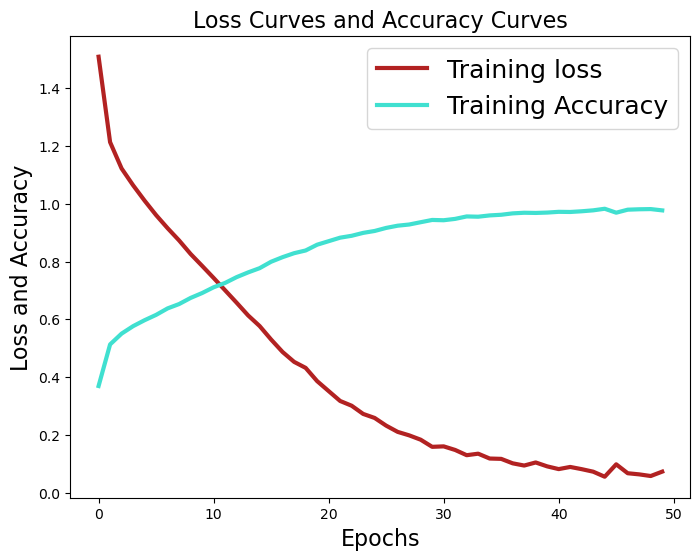

emotion_recognition_model took 11223.827825069427 seconds
27163/27163 ━━━━━━━━━━━━━━━━━━━━ 277s 10ms/step - accuracy: 0.9905 - loss: 0.0312
3395/3395 ━━━━━━━━━━━━━━━━━━━━ 32s 10ms/step - accuracy: 0.7366 - loss: 1.8606
3396/3396 ━━━━━━━━━━━━━━━━━━━━ 32s 9ms/step - accuracy: 0.7361 - loss: 1.9214

**********************************************

 Training accuracy of the model is 99.01

 Testing accuracy of the model is 73.99

 Validation accuracy of the model is 73.17
**********************************************
107/107 ━━━━━━━━━━━━━━━━━━━━ 11s 89ms/step

Classification report for Emotion Recognition
              precision    recall  f1-score   support

           0       0.80      0.84      0.82       586
           1       0.77      0.68      0.72       565
           2       0.73      0.67      0.70       572
           3       0.71      0.74      0.73       584
           4       0.75      0.71      0.73       506
           5       0.69      0.80      0.74       582

    accurac

In [22]:
#function calculates the above code in sequence
#it runs the model and also evaluates the model performance
@calc_time
def main():
  #get train,test data and labels 
  x_train, x_test, y_train, y_test, x_val, y_val, encoder = audio_features_final()
  #call the emotion recognition model
  emotion_recognition_model(x_train,y_train,x_val,y_val)
  #evaluate the model performance
  evaluate_model(x_train, x_test, y_train, y_test, x_val, y_val)

if __name__:main()



In [24]:
x_train, x_test, y_train, y_test, x_val, y_val, encoder = audio_features_final()


Labels or emotions present in dataset
 ['neutral' 'calm' 'happy' 'sad' 'angry' 'fearful' 'disgust' 'surprised'
 'fear' 'Fear' 'Pleasant_surprise' 'Sad' 'pleasant_surprised' 'anger'
 'happiness' 'sadness' 'surprise']

Unique count of labels or emotions after dropping selected labels
 Label
happy      5769
sad        5769
angry      5769
fear       5769
disgust    5769
neutral    5109
Name: count, dtype: int64

Length of the total data is 33954

Length of train data is 27163, test data is 3395 and validation set is 3396

Shape of train features and label is (27163, 178)

Shape of test features and label is (3395, 178)

Shape of validation features and label is (3396, 178)
audio_features_final took 2.594302177429199 seconds


In [25]:
#mapping of the one hot ecoding with respect to their labels
print("\none hot encoding array\n",np.unique(y_train,axis=0))
print("\nOne hot encoding mapping to actual label\n",encoder.inverse_transform(np.unique(y_train,axis=0)))


one hot encoding array
 [[0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]]

One hot encoding mapping to actual label
 [['sad']
 ['neutral']
 ['happy']
 ['fear']
 ['disgust']
 ['angry']]


Recording...
Recording finished.


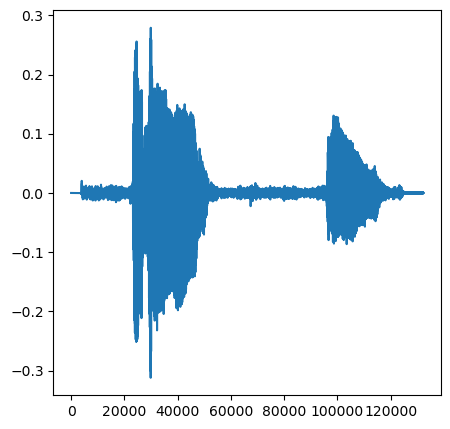

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 969ms/step

The Emotion Predicted For Recorded Audio Using Microphone is ['neutral']


<Figure size 640x480 with 0 Axes>

In [30]:
#this function call is used to record audio using microphone and test the model in real time on speaker voice
test_realtime(encoder)